# Task 9: Business Insights & Executive Report for E-Commerce Dataset
### Internship Project – Elevvo

This notebook performs a full-cycle analysis on the Brazilian Olist E-Commerce dataset.  
We will clean, preprocess, and aggregate sales, product, and customer data, perform exploratory data analysis (EDA), segment customers, and generate actionable business insights.  
Visualizations are included inline with short takeaways for a mini-dashboard feel.

## Steps:
1. Data Loading  
2. Data Cleaning & Preprocessing  
3. Feature Engineering  
4. Exploratory Data Analysis (EDA & Visualizations)  
5. Customer Segmentation (RFM + KMeans)  
6. Insights & Conclusions

## Initialization

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (10,6)

## Step 1: Data Loading

- Load all required datasets (orders, items, products, customers, translations, payments, reviews, sellers, geolocation).  
- Store them in a dictionary for easy access.

In [2]:
base_path = 'data/'

files = {
    'customers': 'olist_customers_dataset.csv',
    'order_items': 'olist_order_items_dataset.csv',
    'order_reviews': 'olist_order_reviews_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'cat_translation': 'product_category_name_translation.csv',
    'geolocation': 'olist_geolocation_dataset.csv',
    'payments': 'olist_order_payments_dataset.csv',
    'orders': 'olist_orders_dataset.csv',
    'sellers': 'olist_sellers_dataset.csv'
}

data = {name: pd.read_csv(base_path + fname, low_memory=False) for name, fname in files.items()}

## Step 2: Data Cleaning & Preprocessing

- Convert timestamps to datetime format  
- Aggregate order items, payments, and reviews  
- Merge datasets into a unified dataframe `orders_basic`

In [3]:
orders = data['orders'].copy()

# Convert date columns to datetime
for c in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
          'order_delivered_customer_date', 'order_estimated_delivery_date']:
    if c in orders.columns:
        orders[c] = pd.to_datetime(orders[c], errors='coerce')

# --------------------------------------------
# 💰 Aggregate Order Data
# --------------------------------------------
order_items = data['order_items'].copy()
order_items['price'] = pd.to_numeric(order_items['price'], errors='coerce')
order_items['freight_value'] = pd.to_numeric(order_items['freight_value'], errors='coerce')

items_agg = order_items.groupby('order_id').agg(
    items_count=('order_item_id', 'count'),
    total_price=('price', 'sum'),
    total_freight=('freight_value', 'sum')
).reset_index()

# Payments
payments = data['payments'].copy()
payments['payment_value'] = pd.to_numeric(payments['payment_value'], errors='coerce')

pay_agg = payments.groupby('order_id').agg(
    total_paid=('payment_value', 'sum'),
    payment_types=('payment_type', lambda x: ','.join(sorted(x.unique())))
).reset_index()

# Reviews
reviews = data['order_reviews'].copy()
reviews['review_score'] = pd.to_numeric(reviews['review_score'], errors='coerce')

rev_agg = reviews.groupby('order_id').agg(
    review_score=('review_score', 'mean')
).reset_index()

# Customers
customers = data['customers'].copy()

# Products with category translation
products = data['products'].copy()
cat_trans = data['cat_translation'].copy()
products = products.merge(cat_trans, how='left', on='product_category_name')

# Merge into orders
orders_basic = (
    orders.merge(items_agg, on='order_id', how='left')
          .merge(pay_agg, on='order_id', how='left')
          .merge(rev_agg, on='order_id', how='left')
          .merge(customers[['customer_id','customer_unique_id','customer_zip_code_prefix']], on='customer_id', how='left')
)

for col in ['items_count', 'total_price', 'total_freight', 'total_paid']:
    orders_basic[col] = orders_basic[col].fillna(0)

## Step 3: Feature Engineering

- Compute `delivery_time_days`  
- Extract `purchase_month` for time-series grouping

In [4]:
orders_basic['delivery_time_days'] = (
    orders_basic['order_delivered_customer_date'] - orders_basic['order_purchase_timestamp']
).dt.days

orders_basic['purchase_month'] = orders_basic['order_purchase_timestamp'].dt.to_period('M')

## Step 4: Exploratory Data Analysis (EDA & Visualizations)

- Monthly revenue trend  
- Items per order distribution  
- Top 12 product categories by revenue  
- Delivery time vs review score

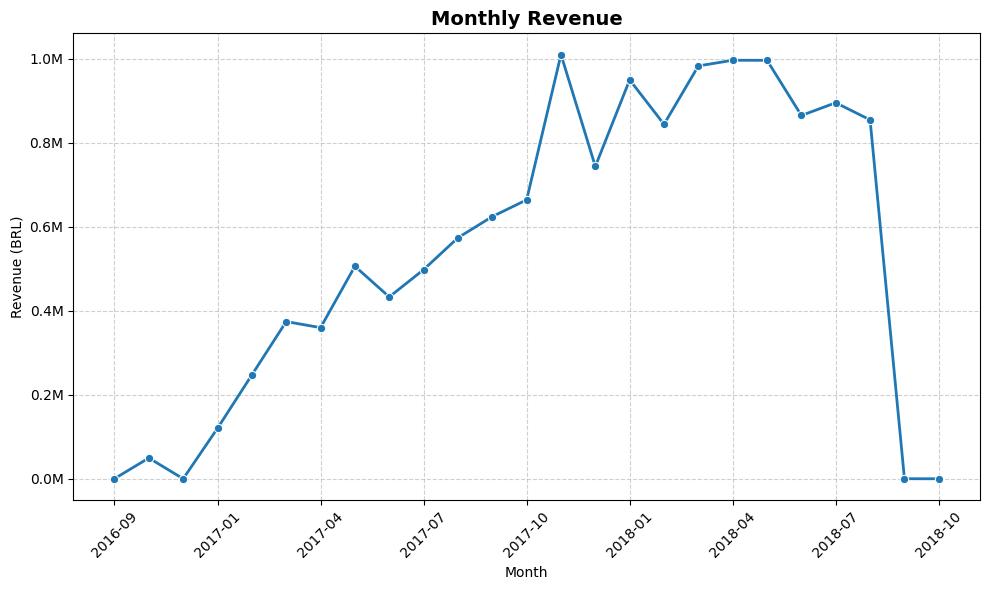

*Takeaway: Revenue grows steadily with seasonal Q4 peaks.*


In [5]:
sales_month = orders_basic.groupby('purchase_month').agg(
    orders=('order_id', 'nunique'),
    revenue=('total_price', 'sum')
).reset_index()

sales_month['purchase_month'] = sales_month['purchase_month'].astype(str)

plt.figure(figsize=(10,6))
ax = sns.lineplot(data=sales_month, x='purchase_month', y='revenue', marker='o', linewidth=2)
ax.set_title('Monthly Revenue', fontsize=14, weight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Revenue (BRL)')
xticks_to_show = sales_month['purchase_month'][::3]
ax.set_xticks(range(0, len(xticks_to_show)*3, 3))
ax.set_xticklabels(xticks_to_show, rotation=45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("*Takeaway: Revenue grows steadily with seasonal Q4 peaks.*")

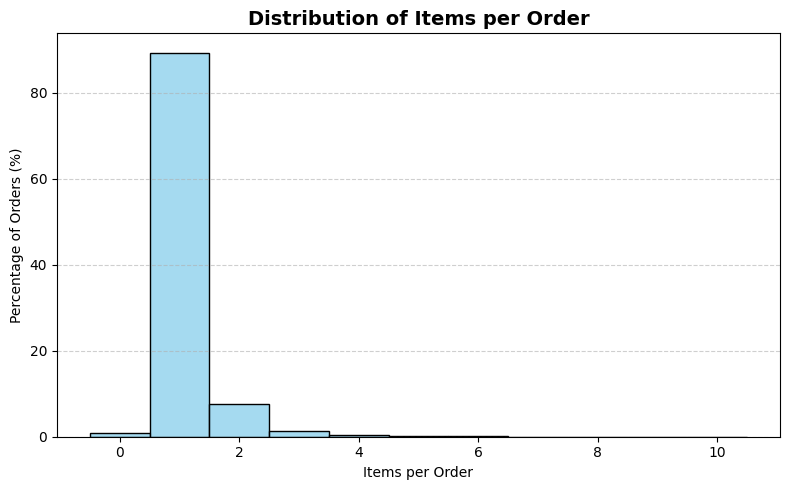

*Takeaway: Most orders contain 1 - 3 items.*


In [6]:
# Items per Order
plt.figure(figsize=(8,5))
data_tmp = orders_basic[orders_basic['items_count'] <= 10]
sns.histplot(data_tmp['items_count'], bins=10, discrete=True, stat='percent', color='skyblue', edgecolor='black')
plt.title('Distribution of Items per Order', fontsize=14, weight='bold')
plt.xlabel('Items per Order')
plt.ylabel('Percentage of Orders (%)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("*Takeaway: Most orders contain 1 - 3 items.*")

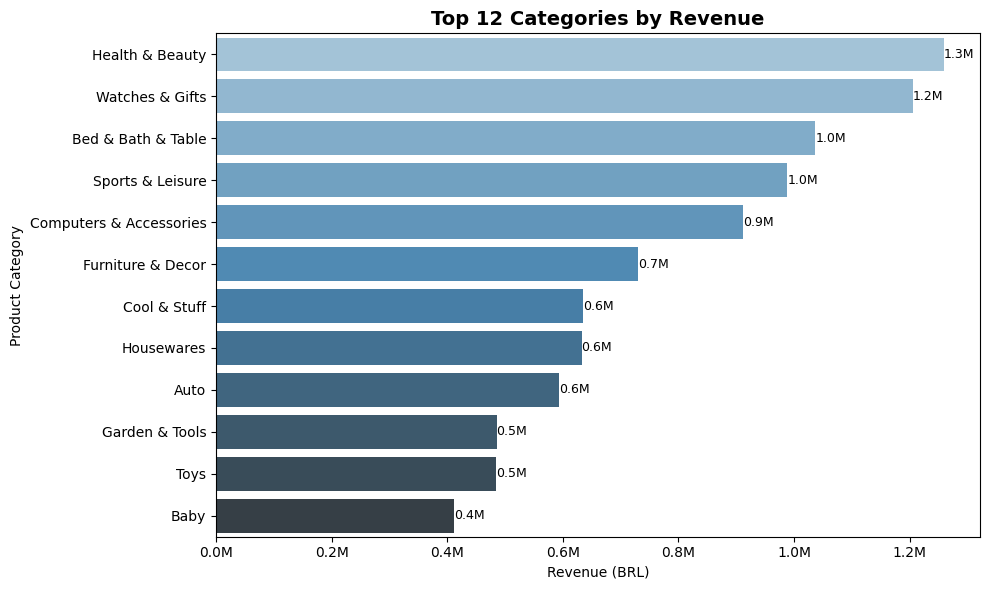

*Takeaway: Top revenue categories are Health & Beauty, Watches & Gifts, Bed & Bath & Table.*


In [7]:
# Top 12 Categories by Revenue
items_products = order_items.merge(products[['product_id','product_category_name_english']], on='product_id', how='left')

cat_rev = (
    items_products.groupby('product_category_name_english')
    .agg(revenue=('price', 'sum'), items_sold=('order_item_id', 'count'))
    .reset_index()
    .sort_values('revenue', ascending=False)
)

cat_rev['category_clean'] = (
    cat_rev['product_category_name_english']
    .fillna('Unknown')
    .str.replace('_', ' & ')
    .str.title()
)

top12 = cat_rev.head(12)

plt.figure(figsize=(10,6))
sns.barplot(data=top12, y='category_clean', x='revenue', palette='Blues_d')
plt.title('Top 12 Categories by Revenue', fontsize=14, weight='bold')
plt.xlabel('Revenue (BRL)')
plt.ylabel('Product Category')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))
for i, value in enumerate(top12['revenue']):
    plt.text(value, i, f'{value/1e6:.1f}M', va='center', fontsize=9)
plt.tight_layout()
plt.show()

top3 = top12['category_clean'].head(3).tolist()
print(f"*Takeaway: Top revenue categories are {', '.join(top3)}.*")

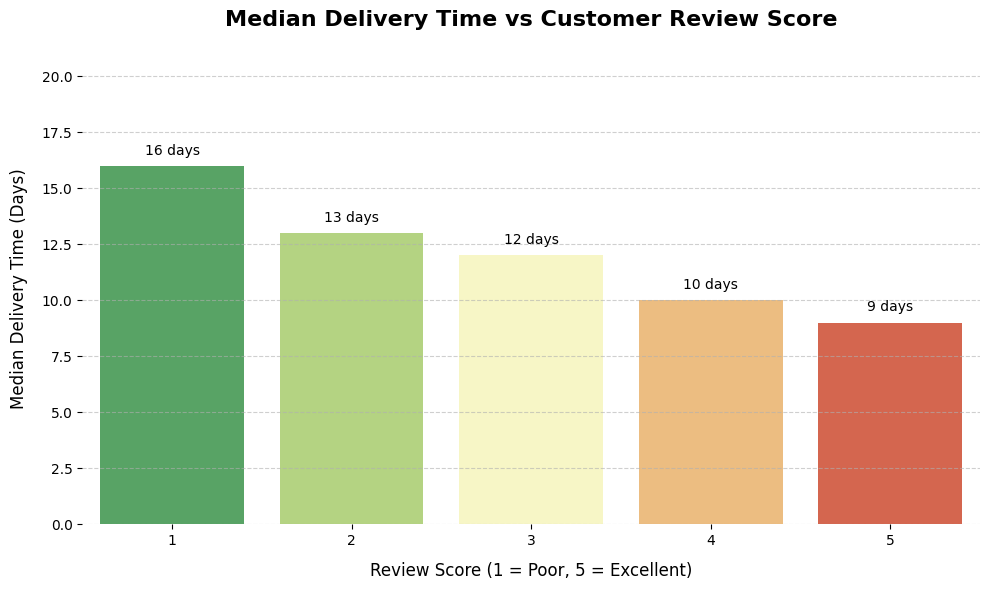

Pearson correlation between delivery_time_days and review_score: -0.334
*Takeaway: Faster deliveries lead to better customer reviews.*


In [8]:
# Delivery Time vs Review Score
data_corr = orders_basic[
    orders_basic['delivery_time_days'].notna() &
    orders_basic['review_score'].notna()
].copy()

data_corr['review_score'] = data_corr['review_score'].astype(float).round().astype(int)
cap = np.percentile(data_corr['delivery_time_days'], 95)
data_corr['delivery_time_days_clipped'] = np.where(
    data_corr['delivery_time_days'] > cap,
    cap,
    data_corr['delivery_time_days']
)

median_delivery = (
    data_corr.groupby('review_score')['delivery_time_days_clipped']
    .median()
    .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=median_delivery,
    x='review_score',
    y='delivery_time_days_clipped',
    palette='RdYlGn_r'
)
plt.title('Median Delivery Time vs Customer Review Score', fontsize=16, weight='bold', pad=20)
plt.xlabel('Review Score (1 = Poor, 5 = Excellent)', fontsize=12, labelpad=10)
plt.ylabel('Median Delivery Time (Days)', fontsize=12, labelpad=10)
for index, row in median_delivery.iterrows():
    plt.text(row.name, row['delivery_time_days_clipped'] + 0.5, f"{int(round(row['delivery_time_days_clipped']))} days", ha='center')
plt.ylim(0, median_delivery['delivery_time_days_clipped'].max() + 5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

corr = orders_basic[['delivery_time_days', 'review_score']].dropna().corr().iloc[0,1]
print('Pearson correlation between delivery_time_days and review_score:', round(corr,3))
print("*Takeaway: Faster deliveries lead to better customer reviews.*")

## Step 5: Customer Segmentation (RFM + KMeans)

- Compute Recency, Frequency, and Monetary metrics  
- Create RFM scores & label customers  
- Run KMeans clustering and generate cluster profiles

In [9]:
snapshot_date = orders_basic['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

cust_agg = orders_basic.groupby('customer_unique_id').agg(
    recency_days=('order_purchase_timestamp', lambda x: (snapshot_date - x.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('total_price', 'sum'),
    avg_order_value=('total_price', 'mean')
).reset_index()

cust_agg['r_quartile'] = pd.qcut(cust_agg['recency_days'], 4, labels=[4,3,2,1]).astype(int)
cust_agg['f_quartile'] = pd.qcut(cust_agg['frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
cust_agg['m_quartile'] = pd.qcut(cust_agg['monetary'], 4, labels=[1,2,3,4]).astype(int)
cust_agg['RFM_score'] = cust_agg['r_quartile'].astype(str) + cust_agg['f_quartile'].astype(str) + cust_agg['m_quartile'].astype(str)

cust_agg['segment'] = cust_agg['RFM_score'].apply(lambda x: 'Top' if x == '444' else ('Loyal' if x[1]=='4' else 'At Risk'))

X = cust_agg[['recency_days','frequency','monetary']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans = KMeans(n_clusters=3, random_state=42)
cust_agg['kmeans_cluster'] = kmeans.fit_predict(X_scaled)

cluster_profile = cust_agg.groupby('kmeans_cluster').agg(
    customers=('customer_unique_id','nunique'),
    recency=('recency_days','median'),
    frequency=('frequency','median'),
    monetary=('monetary','median')
).sort_values('monetary', ascending=False)
print(cluster_profile)
print("*Takeaway: Three customer clusters identified — Top, Loyal, At-Risk.*")

                customers  recency  frequency  monetary
kmeans_cluster                                         
1                    3003    249.0        2.0    179.90
0                   53359    180.0        1.0     87.28
2                   39734    426.0        1.0     84.99
*Takeaway: Three customer clusters identified — Top, Loyal, At-Risk.*


## Step 6: Insights & Conclusions

Final summary of key KPIs and business recommendations.

In [10]:
total_revenue = orders_basic['total_price'].sum()
num_customers = cust_agg['customer_unique_id'].nunique()
avg_order_value = orders_basic['total_price'].mean()
repeat_rate = (cust_agg['frequency']>1).mean()
median_delivery = orders_basic['delivery_time_days'].median()
median_review = orders_basic['review_score'].median()

print("\nBusiness Insights Summary:")
print(f"• Total Revenue: BRL {total_revenue:,.2f}")
print(f"• Unique Customers: {num_customers:,}")
print(f"• Average Order Value: BRL {avg_order_value:,.2f}")
print(f"• Repeat Purchase Rate: {repeat_rate:.1%}")
print(f"• Median Delivery Time: {median_delivery} days")
print(f"• Median Review Score: {median_review}")
if corr < -0.1:
    print("• Negative correlation between delivery time and review score — faster deliveries improve satisfaction.")


Business Insights Summary:
• Total Revenue: BRL 13,591,643.70
• Unique Customers: 96,096
• Average Order Value: BRL 136.68
• Repeat Purchase Rate: 3.1%
• Median Delivery Time: 10.0 days
• Median Review Score: 5.0
• Negative correlation between delivery time and review score — faster deliveries improve satisfaction.
